# カーネル多変量解析

## カーネル回帰

### scikit-learn

In [1]:
from sklearn import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

boston = datasets.load_boston()
df_X = pd.DataFrame(boston.data, columns=boston.feature_names)
s_y = pd.Series(boston.target, name="HousePrice")

df_X_train, df_X_test, s_y_train, s_y_test = train_test_split(df_X, s_y, test_size=0.2)

In [81]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV

parameters = {'alpha':[0.01, 0.1, 1, 10], 'gamma':[0.01, 0.1, 1, 10]}
krr = KernelRidge()
krr_gscv = GridSearchCV(krr, parameters, cv=5)
krr_gscv.fit(df_X_train, s_y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None,
                                   kernel='linear', kernel_params=None),
             iid='warn', n_jobs=None,
             param_grid={'alpha': [0.01, 0.1, 1, 10],
                         'gamma': [0.01, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [4]:
krr_gscv.best_params_

{'alpha': 10, 'gamma': 0.01}

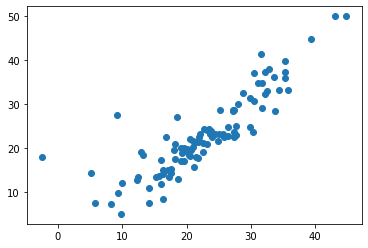

In [83]:
krr = KernelRidge(alpha=10, gamma=0.01)
krr.fit(df_X_train, s_y_train)
y_pred = krr.predict(df_X_test)
plt.scatter(y_pred, s_y_test)

### 自作

In [49]:
from sklearn.metrics.pairwise import euclidean_distances

In [74]:
A = np.array([[1,2,3],[1,3,3],[1,2,3]])
B = np.array([[1,2,3],[4,5,6]])

In [75]:
euclidean_distances(A, B, squared=True)

array([[ 0., 27.],
       [ 1., 22.],
       [ 0., 27.]])

In [145]:
class KernelRegression:
    def __init__(self, alpha=1, kernel_type="rbf", **kwargs):
        self.alpha = alpha
        self.kernel = self.get_kernel(kernel_type, **kwargs)
        self.params = kwargs
    
    def fit(self, X, y):
        if X.ndim == 1: X = X.reshape(-1,1)
        if y.ndim == 1: y = y.reshape(-1,1)
        self.K = self.kernel(X, X)
        self.Inv = np.linalg.inv(self.K + self.alpha * np.eye(self.K.shape[0]))
        self.H = self.Inv @ self.K
        self.a = self.Inv @ y
        self.X_fit = X
        self.cv_score = np.mean(((y - self.H @ y) / (1 - np.diag(self.H).reshape(-1,1)))**2)
        return self
    
    def predict(self, X):
        K_pred = self.kernel(X, self.X_fit)
        return K_pred @ self.a
    
    def get_kernel(self, kernel_type="rbf", gamma=1):
        if kernel_type == "rbf": 
            return lambda A, B: np.exp(- gamma * euclidean_distances(A, B, squared=True))

In [146]:
krr2 = KernelRegression(alpha=0.1, kernel_type="rbf", gamma=0.01)

In [147]:
%%time
krr2.fit(df_X_train.values, s_y_train.values)

CPU times: user 136 ms, sys: 5.42 ms, total: 141 ms
Wall time: 97.1 ms


In [148]:
krr2.cv_score

205.4548738947921

In [154]:
cv_score = {}
for alpha in np.logspace(-3, 2, 10):
    for gamma in np.logspace(-3, 2, 10):
        krr2 = KernelRegression(alpha=alpha, gamma=gamma)
        cv_score[(alpha, gamma)] = krr2.fit(df_X_train.values, s_y_train.values).cv_score

In [156]:
sorted(cv_score.items(), key=lambda x: x[1])[:5]

[((0.046415888336127795, 0.001), 36.79407408360901),
 ((0.01291549665014884, 0.001), 36.938091614938045),
 ((0.003593813663804626, 0.001), 39.02462290393335),
 ((0.1668100537200059, 0.001), 40.56451118663454),
 ((0.001, 0.001), 41.13033766842652)]

In [159]:
krr2 = KernelRegression(alpha=0.15, gamma=0.001)
krr2.fit(df_X_train.values, s_y_train.values)

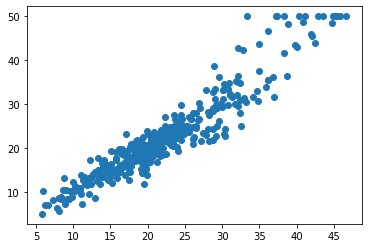

In [161]:
plt.scatter(krr2.predict(df_X_train.values), s_y_train)

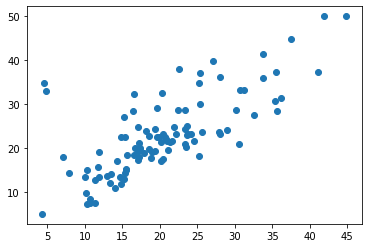

In [160]:
plt.scatter(krr2.predict(df_X_test.values), s_y_test)

## カーネル主成分分析

## サポートベクトルマシン